In [1]:
!pip install pyreclab --upgrade
!pip install psutil
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.2/267.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 21.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, accuracy_score, recall_score
import pyreclab
import scipy.sparse as sparse
import implicit
import psutil
import time
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_df = pd.read_csv(os.path.join('https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/train_w_title.csv'))
train_df.head()

,user_id,book_id,review_text,rating,book_title
0,4289,207,More chick lit than historical fiction; but I ...,1.00,The Other Boleyn Girl (The Plantagenet and Tud...
1,2344,833,This book was a lovely surprise. I don't know ...,0.75,The Golem and the Jinni (The Golem and the Jin...
2,5970,791,I was not liking this book from almost the fir...,0.25,"You (You, #1)"
3,911,216,I first read this for a college course called ...,0.50,Bridge to Terabithia
4,1952,447,I want book two like now.,1.00,"Snow Like Ashes (Snow Like Ashes, #1)"


In [4]:
train_df.shape

(82430, 5)

In [5]:
test_df = pd.read_csv(os.path.join('https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/Archivos%20finales/test_w_title.csv'))
test_df.head()

,user_id,book_id,review_text,rating,book_title
0,4054,236,Extremely well written in translation. Nuanced...,0.75,The Shadow of the Wind (The Cemetery of Forgot...
1,719,878,"I admire Jenny Lawson so much, even more now t...",0.75,Furiously Happy: A Funny Book About Horrible T...
2,3768,396,This book for me is a 4.5 stars books. I bough...,0.75,"Soulless (Parasol Protectorate, #1)"
3,4151,771,The rest of the trilogy could turn this into 5...,0.75,"Annihilation (Southern Reach, #1)"
4,6477,478,I do not understand what all the hype was abou...,0.25,The Underground Railroad


In [6]:
test_df.shape

(21284, 5)

In [7]:
train_data = train_df[['user_id', 'book_id', 'rating']]
test_data = test_df[['user_id', 'book_id', 'rating']]

In [8]:
folder_path = 'datasets'
os.makedirs(folder_path, exist_ok=True)

train_data.to_csv(f'{folder_path}/train.csv', index=False)
test_data.to_csv(f'{folder_path}/test.csv', index=False)

In [9]:
os.listdir(folder_path)

['test.csv', 'train.csv']

In [10]:
# Prueba de hiperparametros
svd = pyreclab.SVD(dataset="datasets/train.csv", dlmchar=b',', header=True, usercol=0, itemcol=1, ratingcol=2)
factor_values = [50, 100, 150, 200, 250] # definir distintos numeros de factores
rmse_values = []

for f in factor_values:
  svd.train(factors=f, maxiter=100, lr=0.005, lamb=0.1)

  predlist, mae, rmse = svd.test(input_file='datasets/test.csv', dlmchar=b',', header=True, usercol=0, itemcol=1, ratingcol=2)

  rmse_values.append(rmse)

print(rmse_values)

[0.23163319467300383, 0.23170300976184763, 0.23184729865238743, 0.23182291396395033, 0.2317272687668946]


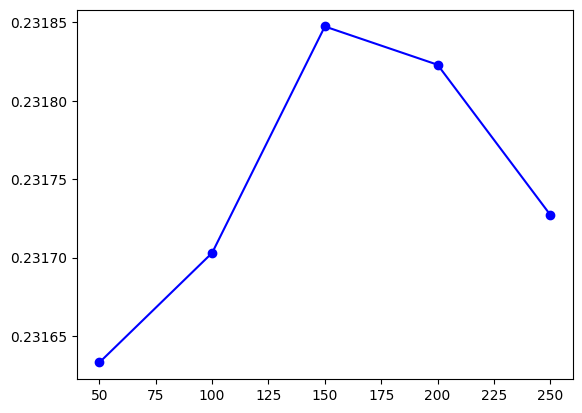

In [11]:
plt.plot(factor_values, rmse_values, 'bo-')
plt.show()

100 factores es lo ideal

In [12]:
svd.train(factors=100, maxiter=100, lr=0.005, lamb=0.1)

In [13]:
# Ratings son relevantes sobre 0.6

def average_precision_for_user(predicted_ratings, actual_ratings, k=10, relevance_threshold=0.6):
    sorted_indices = np.argsort(predicted_ratings)[::-1]
    top_k_indices = sorted_indices[:k]

    relevant_items = actual_ratings[top_k_indices] > relevance_threshold
    precision_at_k = np.mean(relevant_items)

    return precision_at_k

accuracy_values = []
recall_values = []
avg_precision_values = []

for user in test_data['user_id'].unique():
    user_test_data = test_data[test_data['user_id'] == user]

    user_predictions = [svd.predict(str(user), str(book)) for book in user_test_data['book_id']]
    user_actual_ratings = user_test_data['rating'].values

    relevant_items = user_actual_ratings > 0.6
    predicted_relevant_items = np.array(user_predictions) > 0.6
    accuracy = np.mean(np.abs(np.array(user_predictions) - user_actual_ratings) <= 0.1)
    accuracy_values.append(accuracy)

    recall = recall_score(relevant_items, predicted_relevant_items, zero_division=0)
    recall_values.append(recall)

    avg_precision = average_precision_for_user(user_predictions, user_actual_ratings, k=10, relevance_threshold=0.6)
    avg_precision_values.append(avg_precision)

average_accuracy = np.mean(accuracy_values)
average_recall = np.mean(recall_values)
average_avg_precision = np.mean(avg_precision_values)

print(f'Average Accuracy: {average_accuracy:.4f}')
print(f'Average Recall: {average_recall:.4f}')
print(f'Average Precision@10: {average_avg_precision:.4f}')

Average Accuracy: 0.3509
Average Recall: 0.8513
Average Precision@10: 0.7048


In [14]:
import gzip
import json
import re
import sys

def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)

            if (head is not None) and (count > head):
                break
    return data

In [15]:
import requests

DIR = './'

file_names = pd.read_csv(os.path.join('https://media.githubusercontent.com/media/ssilvapinochet/RecSysData/refs/heads/main/dataset_names.csv'))
display(file_names)

file_name_type_mapping = dict(zip(file_names['name'].values, file_names['type'].values))
file_name_url_mapping = {}

for fname in file_name_type_mapping:
    ftype = file_name_type_mapping[fname]
    if ftype == "complete":
        url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/'+fname
        file_name_url_mapping[fname] = url
    elif ftype == "byGenre":
        url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/'+fname
        file_name_url_mapping[fname] = url

from tqdm import tqdm

def download_by_name(fname, local_filename):
        if fname in file_name_url_mapping:
            url = file_name_url_mapping[fname]
            response = requests.get(url, stream=True)
            total_size_in_bytes= int(response.headers.get('content-length', 0))
            with open(local_filename, 'wb') as f:
                with tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True) as pbar:
                    for data in response.iter_content(chunk_size=8192):
                        pbar.update(len(data))
                        f.write(data)
            print('Dataset', fname, 'has been downloaded!')
        else:
            print('Dataset', fname, 'can not be found!')

OUT_DIR = "./books_meta"
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

    output_path = os.path.join(OUT_DIR, 'goodreads_book_genres_initial.json.gz')
    download_by_name('goodreads_book_genres_initial.json.gz', output_path)

,type,name
0,complete,goodreads_book_works.json.gz
1,complete,goodreads_book_authors.json.gz
2,complete,goodreads_book_series.json.gz
3,complete,goodreads_books.json.gz
4,complete,goodreads_book_genres_initial.json.gz
5,byGenre,goodreads_books_children.json.gz
6,byGenre,goodreads_books_comics_graphic.json.gz
7,byGenre,goodreads_books_fantasy_paranormal.json.gz
8,byGenre,goodreads_books_history_biography.json.gz
9,byGenre,goodreads_books_mystery_thriller_crime.json.gz


100%|██████████| 24.3M/24.3M [00:01<00:00, 24.1MiB/s]

Dataset goodreads_book_genres_initial.json.gz has been downloaded!


In [16]:
books_meta_gr = load_data('./books_meta/goodreads_book_genres_initial.json.gz', 10000000)
book_genres = pd.DataFrame(books_meta_gr)
book_genres.head()

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


In [17]:
item_counts = train_df["book_id"].value_counts()
total_interacciones = len(train_df)
items_popularity = item_counts / total_interacciones
items_popularity = items_popularity.to_dict()

In [18]:
book_id_map = {book_id: i for i, book_id in enumerate(train_df['book_id'].unique())}

In [22]:
recommendations = {}

for user in test_data['user_id'].unique():
    recommended_books = svd.recommend(str(user), 10, includeRated=False)
    recommendations[user] = recommended_books

recommendations

{4054: ['313', '786', '462', '472', '769', '356', '638', '40', '96', '38'],
 719: ['313', '786', '462', '472', '40', '38', '638', '769', '288', '455'],
 3768: ['313', '462', '786', '575', '356', '472', '38', '638', '215', '96'],
 4151: ['313', '786', '462', '40', '472', '38', '519', '356', '288', '769'],
 6477: ['313', '786', '990', '462', '472', '356', '40', '638', '288', '38'],
 6607: ['313', '462', '786', '472', '638', '40', '356', '38', '990', '455'],
 4008: ['313', '462', '786', '472', '40', '356', '638', '38', '215', '288'],
 5231: ['313', '786', '462', '356', '472', '40', '288', '96', '519', '769'],
 1001: ['313', '786', '462', '472', '356', '40', '38', '638', '215', '288'],
 3419: ['313', '786', '462', '472', '40', '356', '455', '38', '519', '638'],
 2375: ['313', '786', '462', '472', '356', '40', '638', '575', '38', '990'],
 4806: ['313', '786', '462', '40', '356', '472', '638', '38', '288', '455'],
 4506: ['786', '313', '462', '472', '40', '215', '356', '638', '519', '38'],
 

In [27]:
def calculate_diversity(recommendations, book_genres, k=10):
    book_genres['dominant_genre'] = book_genres['genres'].apply(lambda x: next(iter(x), 'unknown') if x else 'unknown')
    book_id_to_genre = book_genres.set_index('book_id')['dominant_genre'].to_dict()
    diversities = []

    for user_id, recommended_books in recommendations.items():

        genres = {book_id_to_genre.get(str(book_id), 'unknown') for book_id in recommended_books[:k]}
        diversities.append(len(genres) / k if k > 0 else 0)

    return np.mean(diversities) if diversities else 0

def calculate_novelty(recommendations, item_popularity):
  novelties = []
  for user_id, recommended_books in recommendations.items():
      user_novelty = 0
      for book_id in recommended_books:
          book_id = int(book_id)
          if book_id in item_popularity:
              user_novelty += (1 - item_popularity[book_id])
          else:
              user_novelty += 1
      novelties.append(user_novelty / len(recommended_books))
  return np.mean(novelties)

In [28]:
diversity = calculate_diversity(recommendations, book_genres)
novelty = calculate_novelty(recommendations, items_popularity)

print(f"Average Diversity: {diversity:.4f}")
print(f"Average Novelty: {novelty:.4f}")

Average Diversity: 0.5636
Average Novelty: 0.9989
